# word2vec transformation using Tensorflow

[Prashant Brahmbhatt](www.github.com/hashbanger)

______

## The imports

In [0]:
import os
import math
import errno
import random
import zipfile
import collections

from six.moves import urllib
from six.moves import xrange

import numpy as np
import tensorflow as tf

In [0]:
data_dir = "word2vec_data/words/"
data_url = "http://mattmahoney.net/dc/text8.zip"

Now we define a function to fetch the data if no already present

In [0]:
def fetch_words_data(url = data_url, words_data = data_dir):
    
    #make the directory if not present
    os.makedirs(words_data, exist_ok= True)
    
    #path to the zip file
    zip_path = os.path.join(words_data, "words.zip")
    
    #if zip not present download
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(data_url, zip_path)
        
    #Getting the data from the zip file
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    # Return list of all the words in the data source
    return data.decode("ascii").split()

In [0]:
words = fetch_words_data()

Now taking a look how many words we have got and how do they lookm 

In [6]:
len(words)

17005207

In [7]:
# Random slice of words
words[100:120]

['interpretations',
 'of',
 'what',
 'this',
 'means',
 'anarchism',
 'also',
 'refers',
 'to',
 'related',
 'social',
 'movements',
 'that',
 'advocate',
 'the',
 'elimination',
 'of',
 'authoritarian',
 'institutions',
 'particularly']

In [8]:
for word in words[100:140]:
    print(word,end=' ')

interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a 

## Building the Word Count, Creating word count and vocab

Let's see how the **collections.Counter** works

In [9]:
mylist = ['I', 'am', 'vengeance', 'I', 'am', 'the', 'night']
print(collections.Counter(mylist))
print(collections.Counter(mylist).most_common(1))  #To see the one most common word

Counter({'I': 2, 'am': 2, 'vengeance': 1, 'the': 1, 'night': 1})
[('I', 2)]


In [0]:
def create_counts(vocab_size = 50000):
    
    # Creating a list with the most common 50000 words
    vocab = [] + collections.Counter(words).most_common(vocab_size )  # Not same as append
    
    # Converting it into a numpy array
    vocab = np.array([word for word,_ in vocab])  # Iterating for the list of tuples
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words]) #0 to be returned if not found
    
    return data, vocab

In [0]:
vocab_size = 50000

In [0]:
data, vocabulary = create_counts(vocab_size)

Now the **data** contains the ids while the **vocabulary** contains the words

In [14]:
data[:10], vocabulary[:10]

(array([5233, 3080,   11,    5,  194,    1, 3133,   45,   58,  155]),
 array(['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two'],
       dtype='<U28'))

In [19]:
data.shape

(17005207,)

In [20]:
vocabulary.shape

(50000,)

In [22]:
vocabulary[np.random.randint(0,50000)]

'minicomputers'

## Function for the Batches

Here is a function to generate the batches,  
the reference code can be found [here](https://github.com/wangz10/tensorflow-playground/blob/master/word2vec.py).

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [0]:
data_index = 0
batch, labels = generate_batch(batch_size= 8, num_skips= 2, skip_window= 1)

In [26]:
batch, labels

(array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080], dtype=int32),
 array([[5233],
        [  11],
        [  11],
        [5233],
        [  11],
        [5233],
        [  11],
        [5233]], dtype=int32))

## Constants

In [0]:
# size of the batch
batch_size = 128

#Dimension on the embedding vector
embedding_size =  150

# skip window size is the words to consider left and right
skip_window  = 1

# number of skips is the number of times to reuse an input to geenrate a label
num_skips = 2


In [0]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on
valid_size = 16

# Only pick dev samples in the head of the distribution
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace= False)

# Number of negative examples to sample
num_sampled = 64

# model learning rate
learning_rate = 0.001

# how many words in the vocab
vocab_size = 50000

## Tensorflow Constants and Placeholders

In [0]:
tf.reset_default_graph()

# input data
train_inputs = tf.placeholder(tf.int32, shape = [None])
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)

### Variables

In [0]:
# look up embeddings for inputs
init_embeds = tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [0]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev = 1.0/ np.sqrt(embedding_size))) 
nce_biases = tf.Variable(tf.zeros([vocab_size]))

In [0]:
# Construct the variables for the NCE Loss
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.

loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocab_size))

### Optimizer

In [0]:
# Construct the Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 1.0)
trainer = optimizer.minimize(loss)

In [35]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis= 1, keep_dims= True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b= True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Add variable initializer 
init = tf.global_variables_initializer()

## Session

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [38]:
num_steps = 200001

with tf.Session() as sess:
    
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
        
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels : batch_labels}
        
        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([trainer, loss], feed_dict = feed_dict)
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # the average loss is an estimate of the loss over  the last 1000 batches
            print("Average loss at step ",step, " : ", average_loss)
            average_loss = 0
            
            
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0  :  315.683349609375
Average loss at step  1000  :  9800.194437637329
Average loss at step  2000  :  23550.98592930603
Average loss at step  3000  :  26731.26060119629
Average loss at step  4000  :  31061.575930984498
Average loss at step  5000  :  35568.01591528082
Average loss at step  6000  :  37512.8360104866
Average loss at step  7000  :  38877.58411530495
Average loss at step  8000  :  41708.97114128113
Average loss at step  9000  :  42831.42667162228
Average loss at step  10000  :  46473.11032247018
Average loss at step  11000  :  43244.32485685205
Average loss at step  12000  :  49766.55719812345
Average loss at step  13000  :  45704.243123909
Average loss at step  14000  :  42111.87992586249
Average loss at step  15000  :  43151.71297205925
Average loss at step  16000  :  45422.47191720581
Average loss at step  17000  :  43147.94082632446
Average loss at step  18000  :  41930.4474576416
Average loss at step  19000  :  43638.809525900484
Average loss at 

## Visualizing Results

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [43]:
type(final_embeddings)

numpy.ndarray

In [44]:
final_embeddings.shape

(50000, 150)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 5000)

In [0]:
plot_only = 400
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

In [0]:
labels = [vocabulary[i] for i in range(plot_only)]

In [52]:
low_dim_embs.shape

(400, 2)

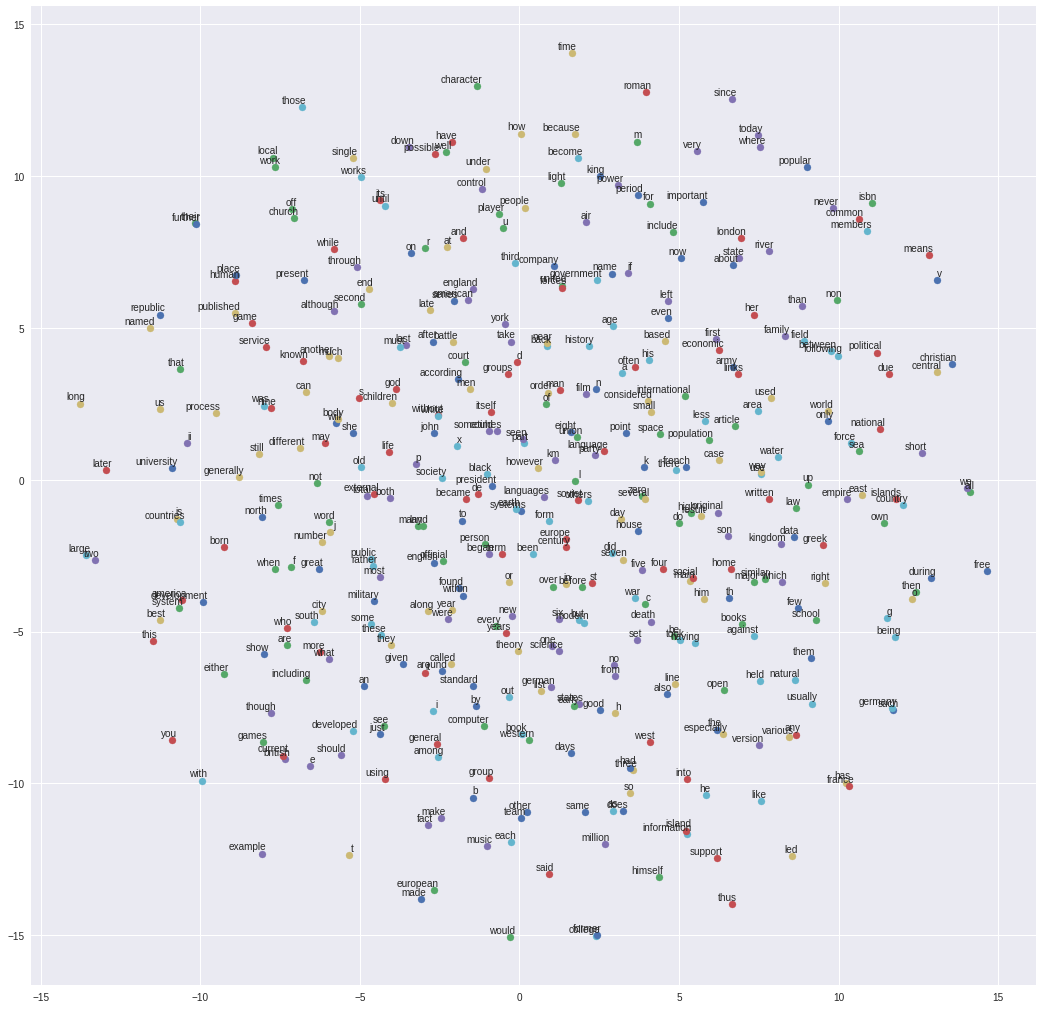

In [53]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

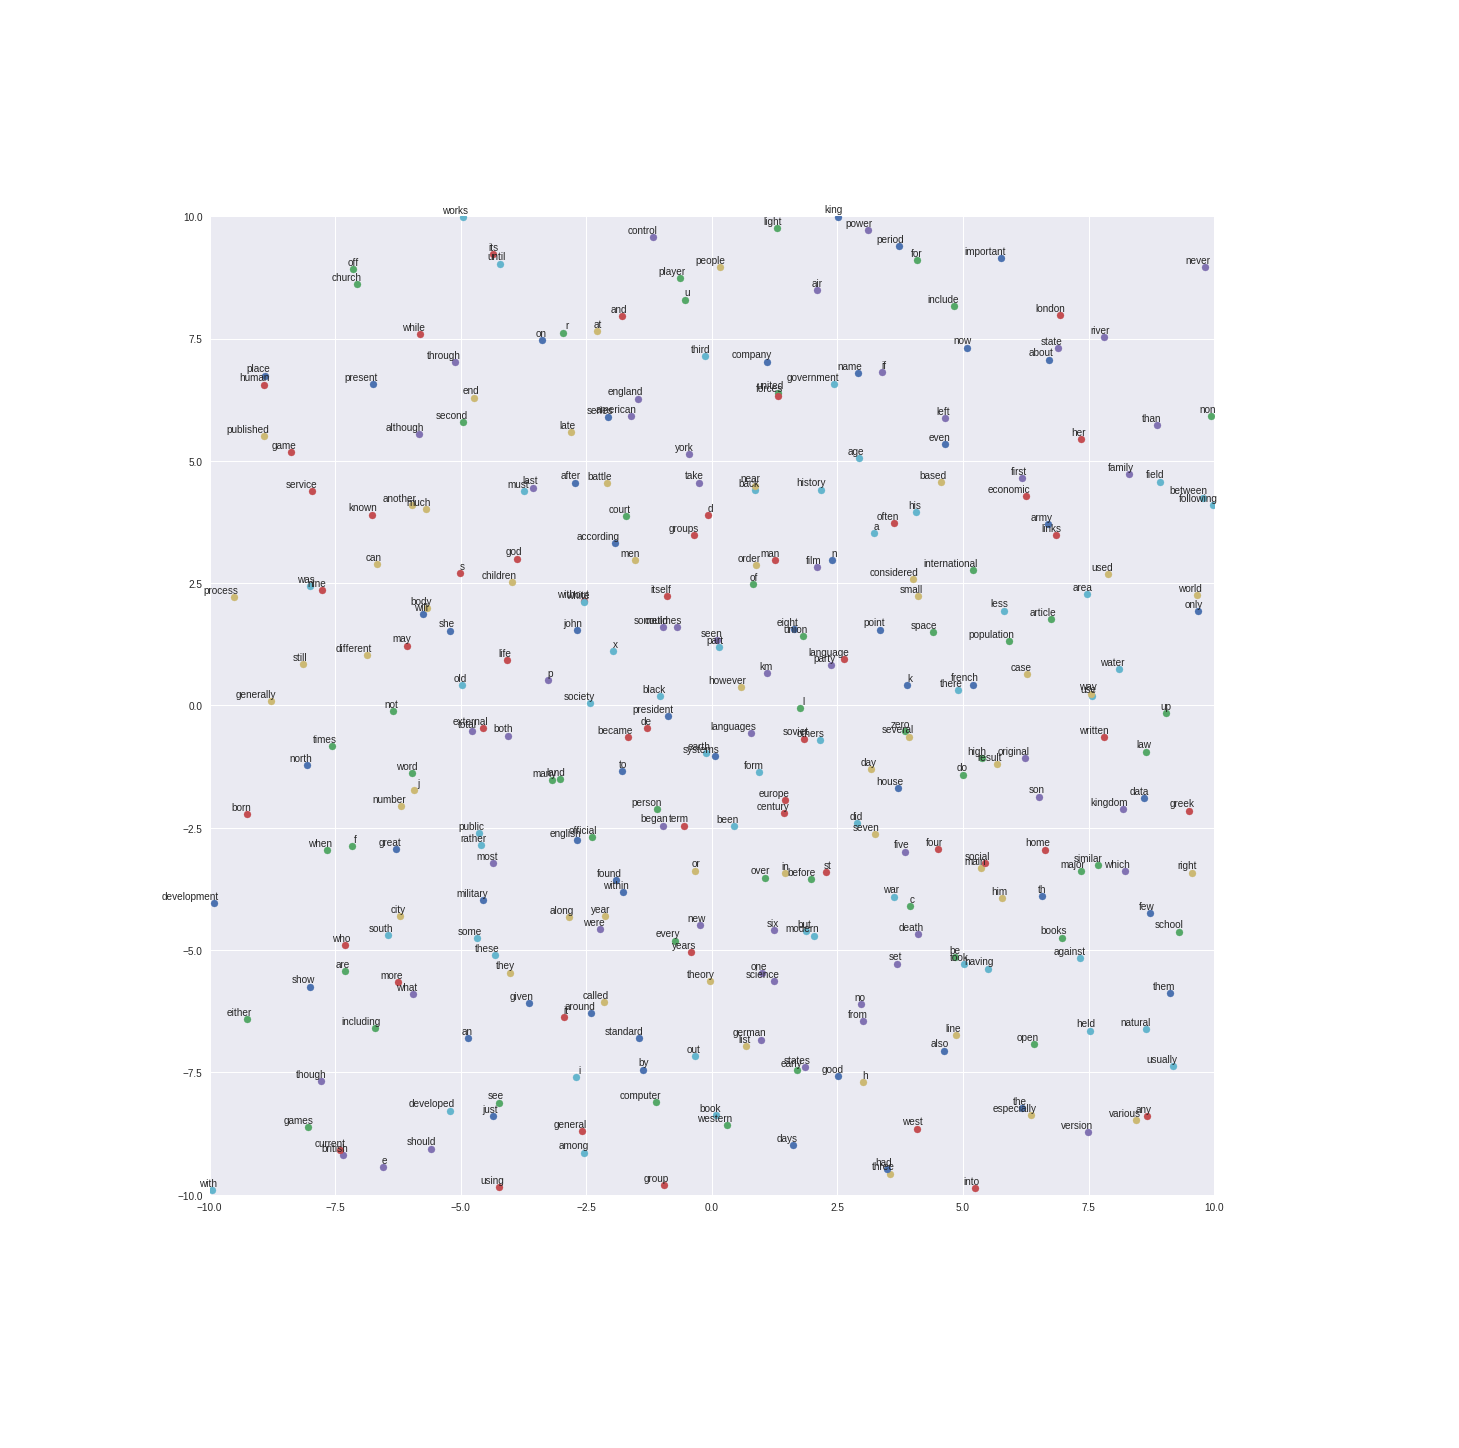

In [54]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

# The best way for word2vec is through the gensim lib

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

### Saving the model

In [0]:
np.save('trained_embeddings_200k_steps_v1',final_embeddings)

### de nada!